# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**
В датафрейме представлены данные о стоимости автомобилей по заданным параметрам.

**Признаки:** 
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак:**
* Price — цена (евро)

## Подготовка данных

### Обзор данных

Импортируем нужные библиотеки, считаем данные из датасетов и напишем функцию, отвечающую за их первичный анализ.

In [1]:
# перейдем в широкоформатный режим  Jupyterи
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# установим необходимые библиотеки
!pip install pandas==1.2.4
!pip install category_encoders

     |████████████████████████████████| 81 kB 1.2 MB/s eta 0:00:01


In [3]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from category_encoders import MEstimateEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
# начальное состояние генератора случайных чисел
RANDOM_STATE = 12345 
# точность округления дробных чисел при выводе в таблице
ACCURACY = 3

In [5]:
# Считаем датафрейм
data = pd.read_csv('/datasets/autos.csv')

In [6]:
# напишем функцию, выполняющую первичный анализ данных
def overview_data(data):
    # выведем первые 20 строк
    display(data.head(20))
    # выведем информацию о датафрейме
    data.info()
    
    # построим общую гистограмму для всех числовых столбцов таблицы
    data.hist(figsize=(15, 20), bins=20);
    plt.show()
    
    # построим диаграммы рассеивания
    sns.pairplot(data);
    plt.show()
    
    # построим тепловую карту матриц корреляции
    f, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(data.corr(), annot=True, square=True);
    plt.title('Тепловая карта матрицы корреляции')
    plt.show()
    
    # выведем описание данных
    display(data.describe())
    
    # посчитаем количество явных дубликатов
    print('Количество явных дубликатов в таблице:', data.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

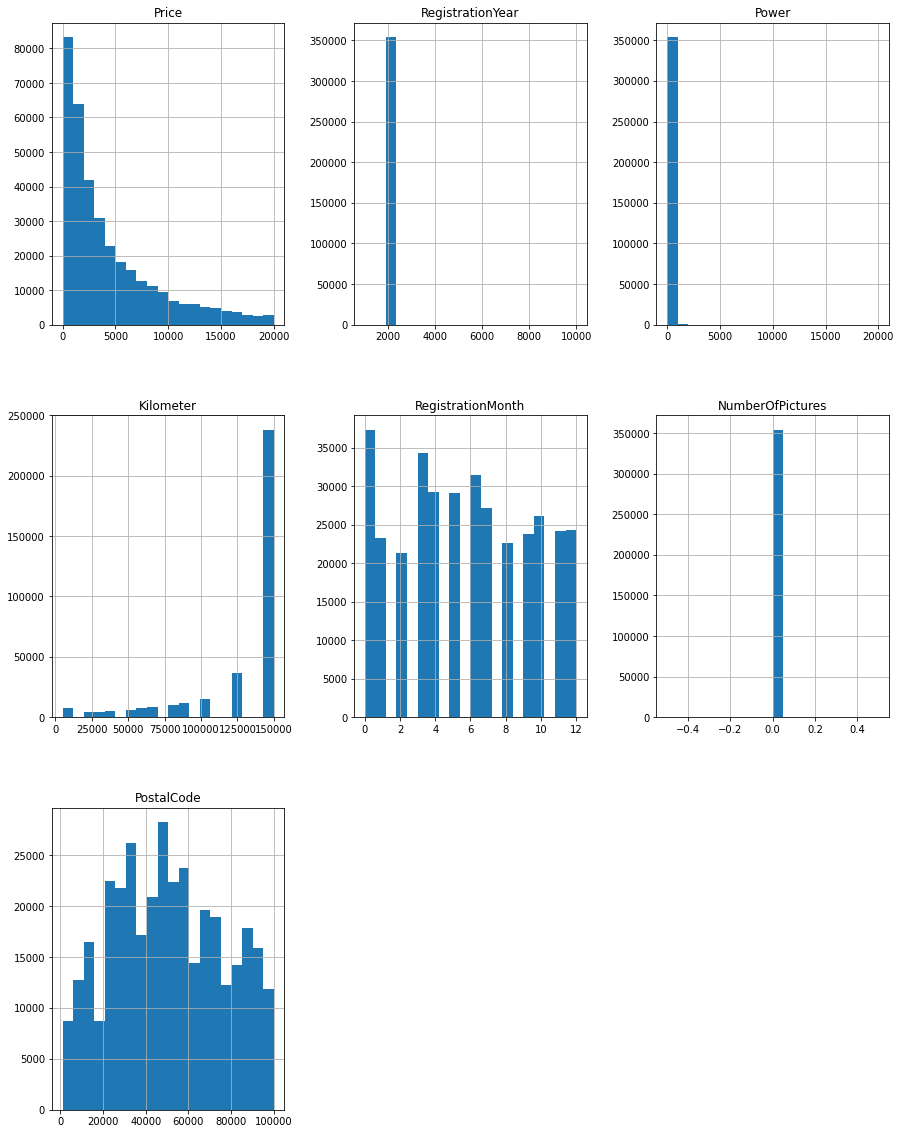

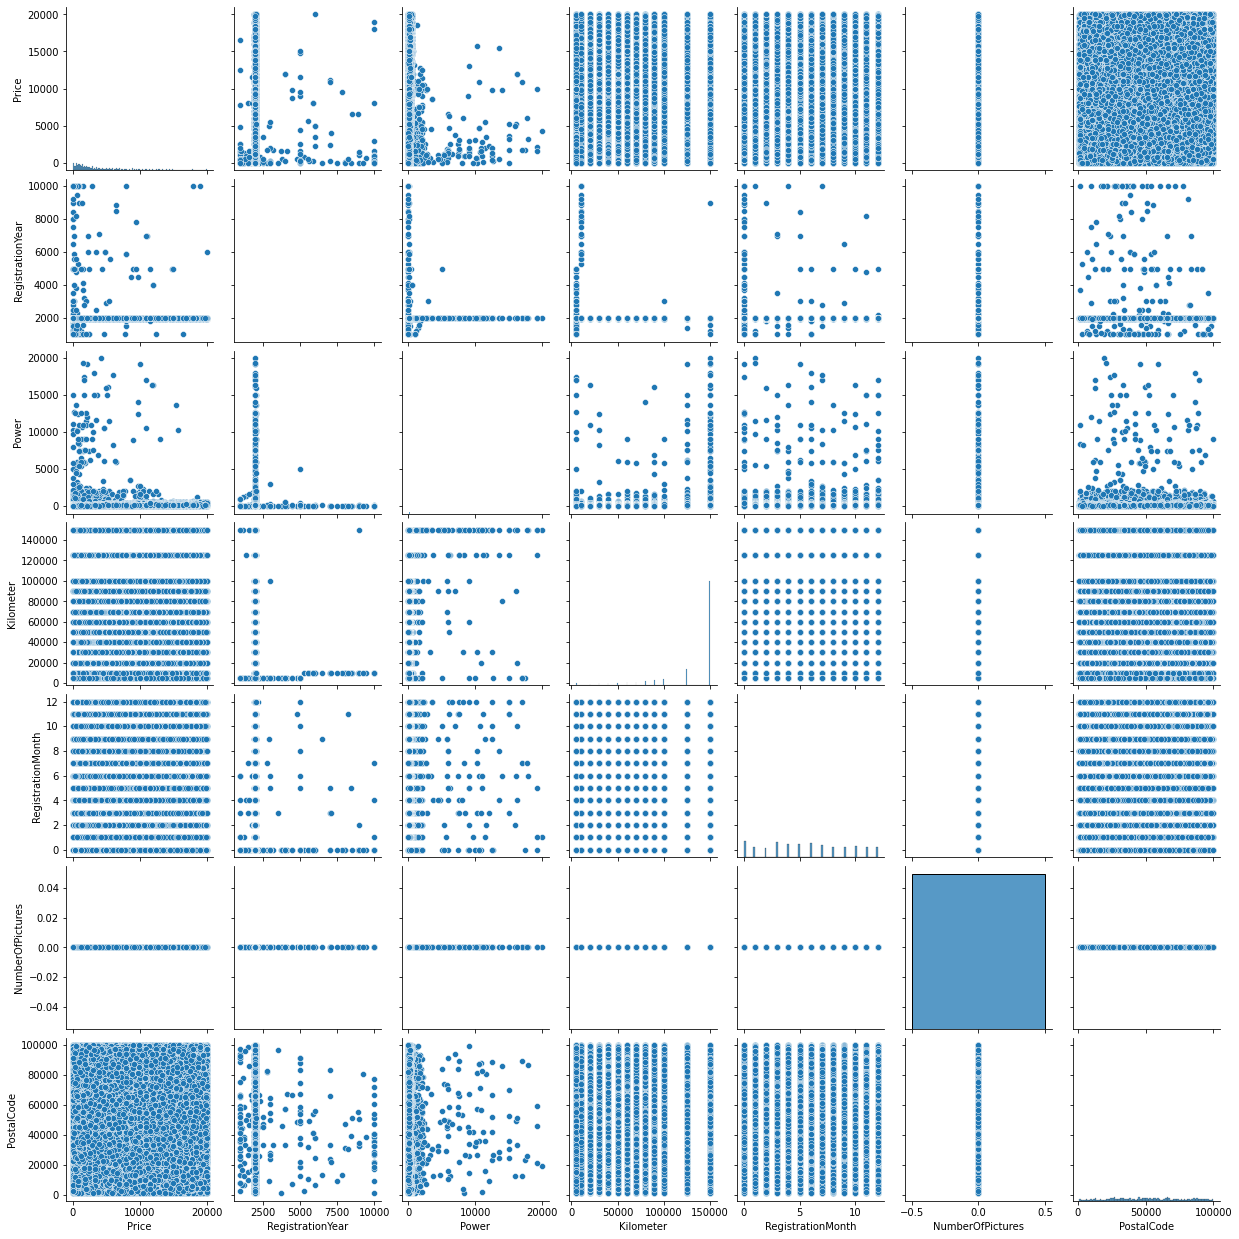

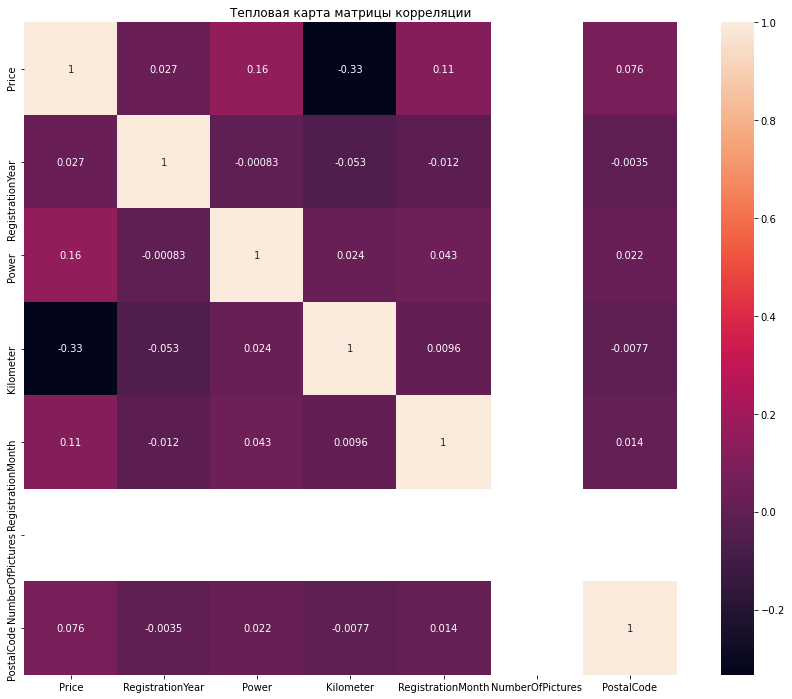

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество явных дубликатов в таблице: 4


In [7]:
# выполним первичный анализ данных для датафрейма
overview_data(data)

Результаты обзора данных:
* В столбце `NumberOfPictures` хранятся только нули, поэтому он не информативен, удалим его.
* Столбцы `PostalCode` и `LastSeen` содержат пользовательскую информацию, которая не влияет на стоимость автомобиля, поэтому для обучения моделей эти столбцы не информативны, удалим их. Столбцы `DateCrawled`, `DateCreated` содержат даты создания и скачивания анкеты, эти параметры тоже не влияют на стоимость автомобиля, так что удалим их тоже. Данные из столбца `RegistrationMonth` не должны влиять на цену автомобиля, поэтому его тоже удалим.
* В целевом столбце `Price` есть нулевые значения, посмотрим, много ли таких данных.
* Столбцы `RegistrationYear`, `Power` имеют данные в некорректном диапазоне, отбросим нереальные данные по ним.
* В нескольких столбцах присутствуют пропуски, требуется их обработать
* После предобработки данных удалим явные дубликаты.

### Исследование выбросов

В целевом столбце `Price` есть нулевые значения, такие значения нам не интересны. Автомобиль не может стоить меньше 50 евро, посмотрим, сколько процентов такие данные составляют:

In [8]:
data[data['Price'] < 50]['Price'].count() / data['Price'].count() * 100

3.505667820830829

Таких данных немного, удалим эти записи:

In [9]:
data.drop(index = data[data['Price'] < 50].index, axis = 0, inplace=True)
data.shape

(341946, 16)

Для определения верхней допустимой границы столбца `RegistrationYear` выведем префиксы, содержащие года создания анкеты из `DateCreated`:

In [10]:
data['DateCreated'].str[:4].unique()

array(['2016', '2015', '2014'], dtype=object)

Столбец `RegistrationYear` содержит данные в некорректном диапазоне, посчитаем, сколько процентов нереальные данных в нем с годом регистрации автомобиля ранее 1950 года и более 2016 года:

In [11]:
data[(data['RegistrationYear'] < 1950) | (data['RegistrationYear'] > 2016)]['RegistrationYear'].count() / data['RegistrationYear'].count() * 100

4.052686681522814

Удалим эти записи:

In [12]:
data.drop(index = data[(data['RegistrationYear'] < 1950) | (data['RegistrationYear'] > 2016)].index, axis = 0, inplace=True)
data.shape

(328088, 16)

В столбце Power есть слишком большие данные: судя по <a href="https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output">списку</a> наиболее мощных серийных автомобилей в мире, максимальная мощность автомобилей - 1500 лошадиных сил (л.с.). А в датасете максимальные значения 20000 л.с. Удалим данные, где значения в Power превышают 1500 л.с.:

In [13]:
data[data['Power'] > 1500]['Power'].count() / data['Power'].count() * 100

0.052120162883128915

In [14]:
data.drop(index = data[data['Power'] > 1500].index, axis = 0, inplace=True)
data.shape

(327917, 16)

### Удаление неинформативных столбцов

В столбце `NumberOfPictures` хранятся только нулиё поэтому он не информативен, удалим его. Также удалим столбцы `PostalCode` и `LastSeen`, содержащие пользовательскую информацию, которая не влияет на стоимость автомобиля. Столбцы `DateCrawled`, `DateCreated` содержат даты создания и скачивания анкеты, эти параметры тоже не влияют на стоимость автомобиля, так что удалим их тоже. Данные из столбца `RegistrationMonth` не должны влиять на цену автомобиля, поэтому его тоже удалим:

In [15]:
data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1, inplace=True)

# проверим, что столбцы удалены
data.columns.values.tolist()

['Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

### Обработка пропусков

Посчитаем число пропусков в столбцах и попробуем их заполнить:

In [16]:
data.isna().sum().sort_values(ascending=False)

Repaired            58799
FuelType            23397
VehicleType         19206
Model               15235
Gearbox             14884
Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
Brand                   0
dtype: int64

Все столбцы с пропусками - категориальные, для незаполненных значений в них введем новую категорию 'undefined' и заполним пропуски этим значением:

In [17]:
data['Repaired'] = data['Repaired'].fillna('undefined')
data['VehicleType'] = data['VehicleType'].fillna('undefined')
data['FuelType'] = data['FuelType'].fillna('undefined')
data['Model'] = data['Model'].fillna('undefined')
data['Gearbox'] = data['Gearbox'].fillna('undefined')

#проверим, что пропуски в датасете заполнены
data.isna().sum().sort_values(ascending=False)

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

### Удаление явных дубликатов

Посмотрим, сколько процентов явных дубликатов осталось после удаления лишних строк и столбцов в предыдущих пунктах и удалим их:

In [18]:
data.duplicated().sum() / data['Power'].count() * 100

12.862401156390185

In [19]:
data = data.drop_duplicates(ignore_index=True)
data.shape

(285739, 10)

<div style="border:solid green 2px; padding: 20px">

* Данные содержат технические характеристики, комплектации и цены автомобилей.
* Столбцы `NumberOfPictures`, `PostalCode`, `LastSeen`,`DateCrawled`, `DateCreated`, `RegistrationMonth` удалены, так как они не информативны.
* Удалены данные, в которых в целевом столбце `Price` указаны значения менее 50 евро.
* Удалены данные с годом регистрации автомобиля `RegistrationYear` ранее 1950 года и более 2016 года.
* Удалены данные с мощностью автомобиля `Power` более 1500 л.с.
* Пропуски в категориальных столбцах `Repaired`, `VehicleType`, `FuelType`, `Model`, `Gearbox`, заполнены заглушкой 'undefined'.
* Удалены явные дубликаты.
    
</div>

## Обучение моделей

### Подготовка данных для обучения моделей

Подготовим тренировочные и тестовые данные для обучения моделей:

In [20]:
features = data.drop('Price', axis=1)
target = data['Price']

# разделим исходные данные на тренировочную и тестовую выборку в соотношении 75:25.
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

Проведем масштабирование числовых признаков, чтобы они воспринимались как одинаково важные:

In [21]:
# определим типы признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285739 entries, 0 to 285738
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             285739 non-null  int64 
 1   VehicleType       285739 non-null  object
 2   RegistrationYear  285739 non-null  int64 
 3   Gearbox           285739 non-null  object
 4   Power             285739 non-null  int64 
 5   Model             285739 non-null  object
 6   Kilometer         285739 non-null  int64 
 7   FuelType          285739 non-null  object
 8   Brand             285739 non-null  object
 9   Repaired          285739 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


In [22]:
# масштабируем числовые признаки
numerical_features_names = ['RegistrationYear', 'Power', 'Kilometer']

# явно укажем, что используются копии таблицы, чтобы не было ошибок при масштабировании
features_train = features_train.copy()
features_test = features_test.copy()

scaler = StandardScaler()
features_train[numerical_features_names] = scaler.fit_transform(features_train[numerical_features_names])
features_test[numerical_features_names] = scaler.transform(features_test[numerical_features_names]) 

Для категориальных признаков воспользуемся кодированием на основе целевого столбца, чтобы модели лучше их обрабатывали:

In [23]:
columns_to_encode = ['VehicleType', 'FuelType', 'Brand', 'Gearbox', 'Repaired', 'Model']

for column in columns_to_encode:
    mestimate_encoder = MEstimateEncoder(cols=[column], m=10, sigma=0.5)
    features_train[[column]] = mestimate_encoder.fit_transform(features_train[column], target_train)

    # Преобразовываем тестовую выборку
    features_test[[column]] = mestimate_encoder.transform(features_test[[column]])

In [24]:
# проверим, что произошло кодирование признаков
features_train.head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
11887,4955.073904,-0.819497,4223.682091,-0.519557,3118.224085,0.597350,4023.368728,2444.125046,5575.093932
151453,4955.073904,0.628659,4223.682091,-1.644534,6632.167843,0.597350,6796.058075,6631.031108,5575.093932
276174,2845.239576,0.918290,4223.682091,-0.009568,9821.600054,-2.301086,6796.058075,9135.743212,5575.093932
252019,2845.239576,-0.674682,4223.682091,-0.519557,2866.112403,0.597350,4023.368728,4780.360449,5575.093932
57980,2845.239576,-0.819497,4223.682091,-0.534557,4587.505833,0.597350,4023.368728,4841.608096,2093.562822
61885,2285.440067,-0.385050,2672.269651,-1.644534,3343.629502,0.597350,2566.290418,4300.602375,2913.357716
53412,6228.696496,0.483844,4223.682091,1.655398,3274.188502,-2.564580,4023.368728,2987.153049,5575.093932
244274,4955.073904,-2.267654,7038.047314,-1.644534,1559.941162,-0.061385,4023.368728,6631.031108,2093.562822
197936,2285.440067,1.932000,2672.269651,-0.744553,4592.693203,0.597350,4023.368728,4780.360449,2913.357716
21742,5024.407178,-1.109129,4223.682091,0.605420,5867.029824,0.597350,4023.368728,6108.378589,5575.093932


## Анализ моделей

Попробуем разные модели для решения задачи, для оценки качества моделей применим метрику RMSE. По требованию задачи значение метрики RMSE должно быть меньше 2500.

Для упрощения напишем функцию, которая с помощью GridSearchCV подбираем лучшую модель по метрике RMSE среди переданных параметров.

In [25]:
# добавь передачу числа итераций в модель
def find_best_model_rmse(model, parameters):
    grid_search = RandomizedSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=3, n_iter=10, n_jobs=-1)
    grid_search.fit(features_train, target_train)

    print('Наилучшая модель', grid_search.best_params_)
    print('RMSE наилучшей модели', abs(grid_search.best_score_))
    
    mean_fit_time = np.mean(grid_search.cv_results_['mean_fit_time'])
    mean_score_time = np.mean(grid_search.cv_results_['mean_score_time'])
    print('Среднее время обучения модели', mean_fit_time)
    print('Среднее время предсказания модели', mean_score_time)
    
    return grid_search.best_estimator_, abs(grid_search.best_score_), mean_fit_time, mean_score_time

### Регрессия дерева решений

Воспользуемся DecisionTreeRegressor для поиска наилучшей модели дерева решений по метрике RMSE:

In [26]:
%%time
dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
dtr_parameters = {'max_depth': range(5,51, 5), 'min_samples_split': range(5, 51, 5), 'min_samples_leaf': range(5, 51, 5)}

dtr_best_estimator, dtr_best_score, dtr_fit_time, dtr_score_time = find_best_model_rmse(dtr_model, dtr_parameters)

Наилучшая модель {'min_samples_split': 35, 'min_samples_leaf': 5, 'max_depth': 20}
RMSE наилучшей модели 1830.6024788413931
Среднее время обучения модели 0.7312016487121583
Среднее время предсказания модели 0.025119129816691083
CPU times: user 12 s, sys: 14.8 ms, total: 12.1 s
Wall time: 24.1 s


### Регрессия случайного леса

Воспользуемся RandomForestRegressor для поиска наилучшей модели случайного дерева по метрике RMSE:

In [27]:
%%time
rfr_model = RandomForestRegressor(random_state=RANDOM_STATE)
rfr_parameters = {"n_estimators": [100, 200], 'max_depth': range(10, 21, 5)}

rfr_best_estimator, rfr_best_score, rfr_fit_time, rfr_score_time = find_best_model_rmse(rfr_model, rfr_parameters)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Наилучшая модель {'n_estimators': 200, 'max_depth': 20}
RMSE наилучшей модели 1684.581678398543
Среднее время обучения модели 79.35183066791957
Среднее время предсказания модели 3.9880366722742715
CPU times: user 14min 2s, sys: 4.1 s, total: 14min 7s
Wall time: 28min 14s


### Регрессия LightGBM

Воспользуемся LGBMRegressor для поиска наилучшей модели LightGBM по метрике RMSE:

In [28]:
%%time
lgbmr_model = LGBMRegressor(random_state=RANDOM_STATE, verbose=1000)
lgbmr_parameters = {'max_depth': [10, 20], 'num_leaves': [100, 300]}

lgbmr_best_estimator, lgbmr_best_score, lgbmr_fit_time, lgbmr_score_time = find_best_model_rmse(lgbmr_model, lgbmr_parameters)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.731152
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.162478
[LightGBM] [Debug] init for col-wise cost 0.205436 seconds, init for row-wise cost 0.290085 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.396263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 142869, number of used features: 9
[LightGBM] [Info] Start training from score 4706.758912
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth 

### Регрессия CatBoost

Воспользуемся CatBoostRegressor для поиска наилучшей модели CatBoost по метрике RMSE:

In [29]:
%%time
cbr_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=1000)
cbr_parameters = {'max_depth': [4, 8], 'learning_rate': [0.1, 0.2]}

cbr_best_estimator, cbr_best_score, cbr_fit_time, cbr_score_time = find_best_model_rmse(cbr_model, cbr_parameters)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 4345.4825037	total: 68ms	remaining: 1m 7s
999:	learn: 1624.5423981	total: 28.4s	remaining: 0us
0:	learn: 4337.9337124	total: 15.5ms	remaining: 15.5s
999:	learn: 1629.8927906	total: 28.4s	remaining: 0us
0:	learn: 4325.3708680	total: 18ms	remaining: 18s
999:	learn: 1626.5291907	total: 29.3s	remaining: 0us
0:	learn: 4302.1636444	total: 25.9ms	remaining: 25.9s
999:	learn: 1422.0028809	total: 44.1s	remaining: 0us
0:	learn: 4295.1555724	total: 33.9ms	remaining: 33.9s
999:	learn: 1424.5525522	total: 46.8s	remaining: 0us
0:	learn: 4290.2558196	total: 29.5ms	remaining: 29.5s
999:	learn: 1424.3827513	total: 44.2s	remaining: 0us
0:	learn: 4090.7927925	total: 54.2ms	remaining: 54.2s
999:	learn: 1564.0249165	total: 28.8s	remaining: 0us
0:	learn: 4083.0864053	total: 15.2ms	remaining: 15.2s
999:	learn: 1570.2796435	total: 30.1s	remaining: 0us
0:	learn: 4072.7686374	total: 17.1ms	remaining: 17.1s
999:	learn: 1568.6669850	total: 29.8s	remaining: 0us
0:	learn: 4003.0028909	total: 23.2ms	remain

Выведем таблицу с результатами вычисления RMSE для используемых выше моделей:

In [30]:
index = ['DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor']

result_data = [
    {'RMSE': dtr_best_score, 'Fit time, s': round(dtr_fit_time, ACCURACY), 'Score time, s': round(dtr_score_time, ACCURACY)},
    {'RMSE': rfr_best_score, 'Fit time, s': round(rfr_fit_time, ACCURACY), 'Score time, s': round(rfr_score_time, ACCURACY)},
    {'RMSE': lgbmr_best_score, 'Fit time, s': round(lgbmr_fit_time, ACCURACY), 'Score time, s': round(lgbmr_score_time, ACCURACY)},
    {'RMSE': cbr_best_score, 'Fit time, s': round(cbr_fit_time, ACCURACY), 'Score time, s': round(cbr_score_time, ACCURACY)},
]

result_table = pd.DataFrame(result_data, index=index)
result_table.sort_values(by='RMSE')

,RMSE,"Fit time, s","Score time, s"
LGBMRegressor,1615.237754,1401.305,1.047
CatBoostRegressor,1619.241824,40.609,0.158
RandomForestRegressor,1684.581678,79.352,3.988
DecisionTreeRegressor,1830.602479,0.731,0.025


<div style="border:solid green 2px; padding: 20px">
    
* Наилучший результат по метрике RMSE выдали модели градиентного бустинга: LightGBM - 1615,  CatBoost - 1619. Далее идет модель случайного леса с RMSE 1694. Наихудший результат RMSE у модели дерева решений 1832.
* Наименьшее время обучение модели у модели дерева решений, оно составляет 0.3 сек, наибольшее время обучения у модели LightGBM - 1 сек.
* Наименьшее время предсказания модели у модели дерева решений, оно составляет 0.01 сек, наибольшее время предсказания у модели случайного леса - 1.74 сек. 
* По совокупности критериев заказчика: RMSE, время обучения модели и время предсказания модели выберем модель CatBoost для решения задачи определения стоимости автомобилей, так как значения RMSE у них близки, а по сравнению с моделью LightGBM время обучения меньше почти в 10 раз, а время предсказания меньше в 13 раз.

</div>

## Тестирование и проверка на адекватность лучшей модели

### Тестирование лучшей модели

Проверим, как лучшая модель CatBoost отрабатывает на тестовой выборке:

In [31]:
# определим функцию, вычиляющую RMSE модели на тестовой выборке
def test_model(best_estimator):
    predictions_test = best_estimator.predict(features_test)

    rmse_test =  np.sqrt(mean_squared_error(target_test, predictions_test))
    print('Итоговый RMSE на тестовой выборке', rmse_test) 

In [32]:
# протестируем модель CatBoost
test_model(cbr_best_estimator)

Итоговый RMSE на тестовой выборке 1620.0339440923924


### Проверка на адекватность лучшей модели

Сравним, как соотносятся полученные результаты с результатами фиктивного регрессора, который всегда будет предсказывать среднее значение или медиану тренировочного целевого признака:

In [33]:
dr_model = DummyRegressor()
dr_parameters = {'strategy' : ['mean', 'median']}

dr_best_estimator, dr_best_score, dr_fit_time, dr_score_time = find_best_model_rmse(dr_model, dr_parameters)
test_model(dr_best_estimator)

Наилучшая модель {'strategy': 'mean'}
RMSE наилучшей модели 4603.614551678966
Среднее время обучения модели 0.016719539960225422
Среднее время предсказания модели 0.0009077787399291992
Итоговый RMSE на тестовой выборке 4584.749930448955


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


<div style="border:solid green 2px; padding: 20px">
    
* Наилучшая модель CatBoost на тестовой выборке вычислила RMSE 1620, почти то же, что и на тренировочной выборке: 1619, значит, модель хорошо обучилась на тренировочной выборке и успешно обобщила свое обучение на тестовой выборке.
* Сравнили результат наилучшей найденной модели CatBoost с фиктивным регрессором, который всегда будет предсказывать медиану тренировочного целевого признака: на тестовой выборке модель CatBoost показала RMSE 1620, а фиктивный регрессор 4585, т.е. ошибка получилась в 2.8 раза меньше.
    
</div>

## Общие выводы

<div style="border:solid green 2px; padding: 20px">
    
* В проектре **требовалось построить модель, предсказывающую рыночную стоимость автомобиля** для сервиса по продаже автомобилей с пробегом.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Данные содержат технические характеристики, комплектации и цены автомобилей.
* Столбцы `NumberOfPictures`, `PostalCode`, `LastSeen`,`DateCrawled`, `DateCreated`, `RegistrationMonth` удалены, так как они не информативны.
* Удалены данные, в которых в целевом столбце `Price` указаны значения менее 50 евро.
* Удалены данные с годом регистрации автомобиля `RegistrationYear` ранее 1950 года и более 2016 года.
* Удалены данные с мощностью автомобиля `Power` более 1500 л.с.
* Пропуски в категориальных столбцах `Repaired`, `VehicleType`, `FuelType`, `Model`, `Gearbox`, заполнены заглушкой 'undefined'.
* Удалены явные дубликаты.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* **Наилучший результат по метрике RMSE выдали модели градиентного бустинга: LightGBM - 1615,  CatBoost - 1619.** Далее идет модель случайного леса с RMSE 1694. Наихудший результат RMSE у модели дерева решений 1832.
* Наименьшее время обучение модели у модели дерева решений, оно составляет 0.3 сек, наибольшее время обучения у модели LightGBM - 1 сек.
* Наименьшее время предсказания модели у модели дерева решений, оно составляет 0.01 сек, наибольшее время предсказания у модели случайного леса - 1.74 сек. 
* **По совокупности критериев заказчика: RMSE, время обучения модели и время предсказания модели выбрали модель CatBoost для решения задачи определения стоимости автомобилей**, так как значения RMSE у них близки, а по сравнению с моделью LightGBM время обучения меньше почти в 10 раз, а время предсказания меньше в 13 раз.     
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* **Наилучшая модель CatBoost** на тестовой выборке вычислила RMSE 1620, почти то же, что и на тренировочной выборке: 1619, значит, модель **хорошо обучилась на тренировочной выборке и успешно обобщила свое обучение на тестовой выборке**.
* Сравнили результат наилучшей найденной модели CatBoost с фиктивным регрессором, который всегда будет предсказывать медиану тренировочного целевого признака: **на тестовой выборке модель CatBoost показала RMSE 1620, а фиктивный регрессор 4585, т.е. ошибка получилась в 2.8 раза меньше.**
    
</div>